In [1]:
!pip install --upgrade qiskit==1.3.1 qiskit-machine-learning==0.8.2 pylatexenc qiskit_algorithms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.9 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=e308adeaa8c8cb5b3943d7b0de52b642594dbbddf3a1554735b54c4aab1617d9
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import U3Gate, ZZFeatureMap, ZFeatureMap, RealAmplitudes
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator
from qiskit.circuit import Gate, Parameter, ParameterVector
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit.primitives import Sampler, Estimator
from qiskit_machine_learning.optimizers import COBYLA, SPSA, L_BFGS_B
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pickle import load
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


0


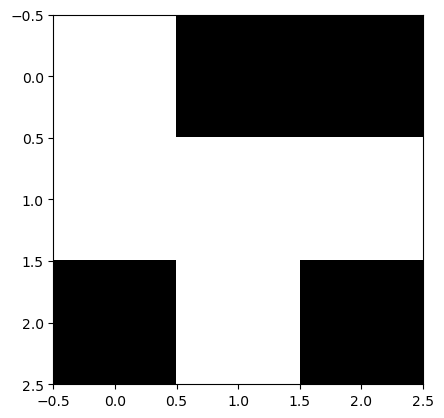

In [2]:
with open('./dataset.obj',"rb") as f:
    dataset_loaded = load(f)
plt.imshow(dataset_loaded[1][0],cmap="gray")
print(dataset_loaded[0][1])

In [4]:
data = np.array([x[0].flatten() for x in dataset_loaded])
labels = np.array([x[1] for x in dataset_loaded])
if data.dtype == bool:
    data = data.astype(np.float32)
data = (data - np.min(data)) / (np.max(data) - np.min(data))
print(len(data))

104


In [5]:
for i in range(len(data)):
  if labels[i] == 0:
    labels[i] = -1
print(labels)

[-1  1  1  1 -1  1 -1  1  1 -1 -1 -1  1 -1  1 -1  1 -1  1 -1 -1 -1 -1  1
  1  1 -1  1  1 -1 -1  1  1  1 -1 -1  1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1
  1  1 -1  1  1  1 -1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1  1  1 -1
 -1  1 -1 -1  1 -1  1  1  1 -1  1 -1  1  1 -1  1 -1  1 -1  1  1 -1 -1 -1
  1 -1  1  1 -1  1 -1  1]


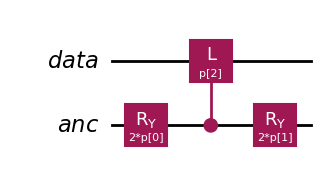

In [9]:
# Residual block with two trainable rotations (index added to avoid param conflicts)
def residual_block_r2(l_gate: Gate, params, idx):
    anc = QuantumRegister(1, 'anc')
    data = QuantumRegister(1, 'data')
    qc = QuantumCircuit(data, anc, name="R2_block")


    qc.ry(2 * params[idx], anc[0])
    controlled_l = l_gate.control(1)
    qc.append(controlled_l, [anc[0], data[0]])
    qc.ry(2 * params[idx + 1], anc[0])

    return qc


# Feature encoding using residual and Ry blocks
params = ParameterVector("p", 3)
l_circuit = QuantumCircuit(1)
l_circuit.ry(params[2], 0)
l_gate = l_circuit.to_gate(label="L")
qc = residual_block_r2(l_gate, params, 0)
qc.draw("mpl")

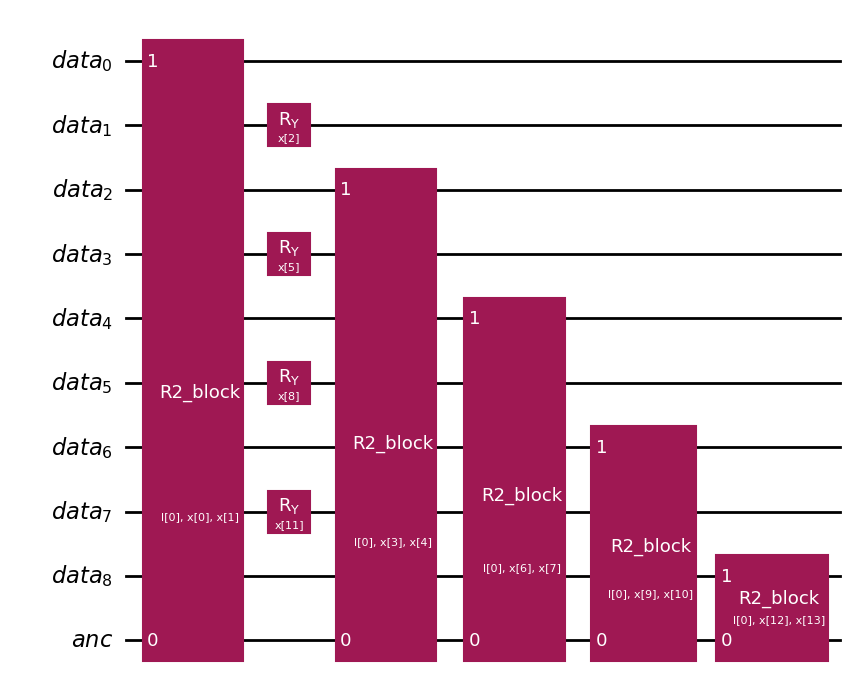

In [25]:
# Alternating feature map with R2 and Ry
def alternating_encoding_with_r2(n_qubits, ancilla, param_vec, l_param):
    data = QuantumRegister(n_qubits, 'data')
    qc = QuantumCircuit(data, ancilla, name = "Residual Layer")

    # Define L gate: U(x) = Ry(x)
    l_circuit = QuantumCircuit(1)
    l_circuit.ry(l_param[0], 0)
    l_gate = l_circuit.to_gate(label="L")

    p_idx = 0

    for i in range(n_qubits):
        if i % 2 == 0:
            # Apply R2 block
            r2 = residual_block_r2(l_gate, param_vec, p_idx)
            qc.append(r2, [ancilla[0], data[i]])
            p_idx += 2
        else:
            # Apply simple Ry
            qc.ry(param_vec[p_idx], data[i])
            p_idx += 1

    return qc

# Example usage
ancilla = QuantumRegister(1, 'anc')
params = ParameterVector("x", 20)
l_params = ParameterVector("l", 1)
circ = alternating_encoding_with_r2(9, ancilla, params, l_params)
circ.draw("mpl")

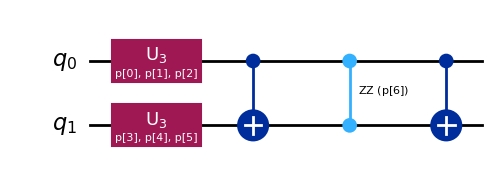

In [29]:
# Define convolutional layer
def conv_layer(qubits, weight_params, idx):
    qc = QuantumCircuit(len(qubits), name="Convolution")

    for i, q in enumerate(qubits):
        theta, phi, lam = weight_params[idx], weight_params[idx + 1], weight_params[idx+2]
        idx += 3
        qc.append(U3Gate(theta, phi, lam), [q])
    for i in range(len(qubits) - 1):
        qc.cx(i, i+1)
        qc.rzz(weight_params[idx], i,  i+1)
        qc.cx(i, i+1)
    return qc


# qubits = list(range(2))
qubits = [0,1]
params = ParameterVector("p", 7)  # 4*3 (for U3) + 1 (for ZZ)
conv = conv_layer(qubits, params, 0)
conv.draw("mpl")

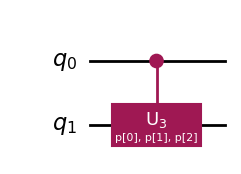

In [21]:
# Define pooling layer
def pooling_layer(ctrl, tgt, params):
    qc = QuantumCircuit(2, name="Pooling")
    u3_gate = U3Gate(*params)
    cu3 = u3_gate.control(1)
    qc.append(cu3, [0, 1])
    return qc

pool_params = ParameterVector("p", 3)
pool_circ = pooling_layer(0, 1, pool_params)
pool_circ.draw("mpl")

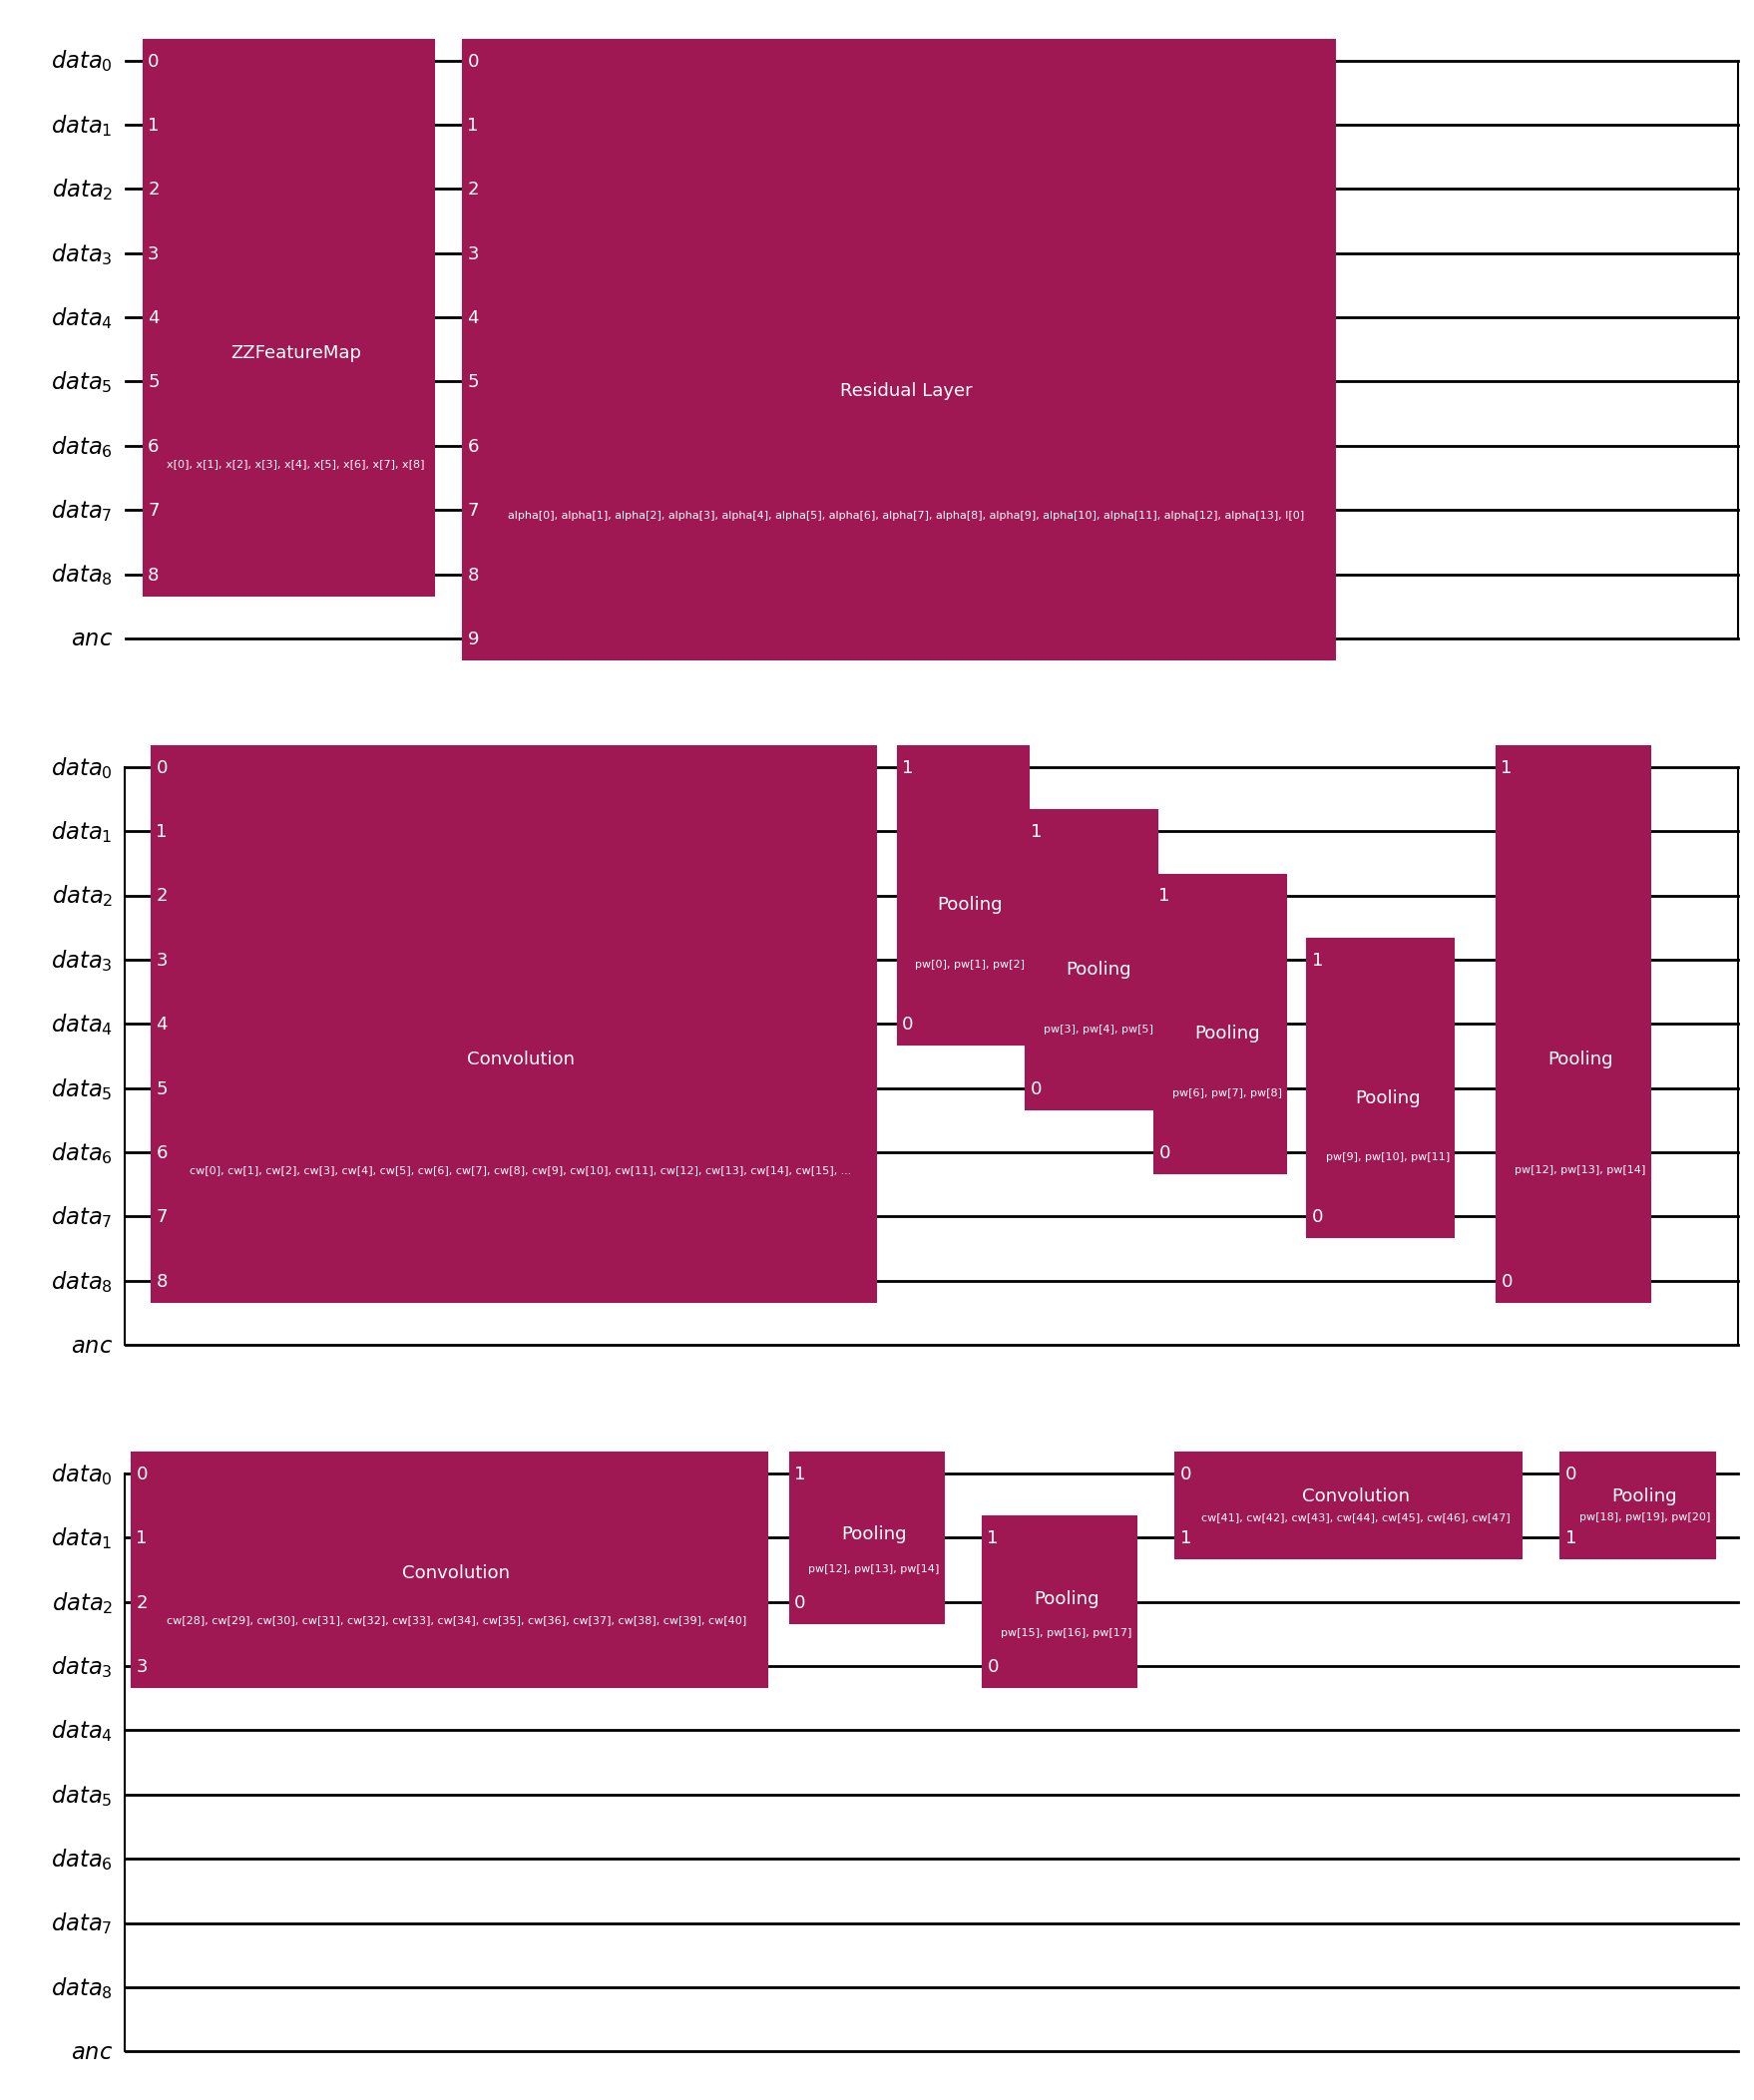

In [30]:
# Build QCNN circuit
def build_qcnn():
    data = QuantumRegister(9, 'data')
    ancilla = QuantumRegister(1, 'anc')
    qc = QuantumCircuit(data, ancilla)

    # ZZFeatureMap with parameters
    feature_map = ZZFeatureMap(feature_dimension=9, reps=2)
    input_params = feature_map.parameters
    qc.compose(feature_map, qubits=data[:], inplace=True)

    res_params = ParameterVector("alpha", 14)
    l_param = ParameterVector("l", 1)
    res_layer = alternating_encoding_with_r2(9, ancilla, res_params, l_param)
    qc.append(res_layer.to_instruction(), data[:] + ancilla[:])
    
    # Define trainable parameters
    conv_weights = ParameterVector('cw', 48)
    pool_weights = ParameterVector('pw', 21)  # 7 pooling layers, 3 params each = 21

    # Layer 1 - Convolution (9 qubits)
    conv1 = conv_layer(list(range(9)), conv_weights, 0)
    qc.append(conv1.to_instruction(), data[:])

    # Layer 2 - Pooling (9 -> 4)
    pool_pairs = [(4, 0), (5, 1), (6, 2), (7, 3), (8, 0)]
    for i, (ctrl, tgt) in enumerate(pool_pairs):
        idx = i * 3
        pool = pooling_layer(0, 1, pool_weights[idx:idx+3])
        qc.append(pool.to_instruction(), [data[ctrl], data[tgt]])

    # Layer 3 - Convolution (4 qubits)
    conv2 = conv_layer(list(range(4)), conv_weights, 28)
    qc.append(conv2.to_instruction(), data[0:4])

    # Layer 4 - Pooling (4 -> 2)
    pool2_pairs = [(2, 0), (3, 1)]
    for i, (ctrl, tgt) in enumerate(pool2_pairs):
        idx = 12 + i * 3
        pool = pooling_layer(0, 1, pool_weights[idx:idx+3])
        qc.append(pool.to_instruction(), [data[ctrl], data[tgt]])

    # Layer 5 - Convolution (2 qubits)
    conv3 = conv_layer(list(range(2)), conv_weights, 41)
    qc.append(conv3.to_instruction(), data[0:2])

    # Layer 6 - Pooling (2 -> 1)
    pool3 = pooling_layer(1, 0, pool_weights[18:21])
    qc.append(pool3.to_instruction(), [data[0], data[1]])
    full_weight_params = list(res_params) + list(l_param) + list(conv_weights) + list(pool_weights)

    return qc, input_params, full_weight_params

qcnn_circuit, input_params, weight_params = build_qcnn()
qcnn_circuit.draw("mpl")

In [47]:
print((input_params))
print((weight_params))

ParameterView([ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(x[2]), ParameterVectorElement(x[3]), ParameterVectorElement(x[4]), ParameterVectorElement(x[5]), ParameterVectorElement(x[6]), ParameterVectorElement(x[7]), ParameterVectorElement(x[8])])
[ParameterVectorElement(alpha[0]), ParameterVectorElement(alpha[1]), ParameterVectorElement(alpha[2]), ParameterVectorElement(alpha[3]), ParameterVectorElement(alpha[4]), ParameterVectorElement(alpha[5]), ParameterVectorElement(l[0]), ParameterVectorElement(cw[0]), ParameterVectorElement(cw[1]), ParameterVectorElement(cw[2]), ParameterVectorElement(cw[3]), ParameterVectorElement(cw[4]), ParameterVectorElement(cw[5]), ParameterVectorElement(cw[6]), ParameterVectorElement(cw[7]), ParameterVectorElement(cw[8]), ParameterVectorElement(cw[9]), ParameterVectorElement(cw[10]), ParameterVectorElement(cw[11]), ParameterVectorElement(cw[12]), ParameterVectorElement(cw[13]), ParameterVectorElement(cw[14]), Parameter

In [23]:

observables = SparsePauliOp.from_list([
    ("ZIIIIIIII", 1),
])
estimator = StatevectorEstimator()
gradient = ParamShiftEstimatorGradient(estimator)

qnn = EstimatorQNN(
    circuit=qcnn_circuit,
    input_params=input_params,
    weight_params=weight_params,
    estimator=estimator,
    observables=observables,
    gradient=gradient
)

initial_point = np.random.rand(qnn.num_weights)
loss_vals = []
batch_size = 16
num_batches = int(np.ceil(len(data) / batch_size))

def callback_graph(weights, loss):
    correct = 0
    for i in range(num_batches):
        batch_data = data[i * batch_size:(i + 1) * batch_size]
        batch_labels = labels[i * batch_size:(i + 1) * batch_size]
    print(f"Loss: {loss:.4f}")
    loss_vals.append(loss)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),
    initial_point=initial_point,
    loss="squared_error",
    callback=callback_graph,
)



classifier.fit(data, labels)
accuracy = classifier.score(data, labels)
print(f"Final Accuracy: {accuracy:.2f}")

Loss: 0.9848
Loss: 0.9873
Loss: 0.9837
Loss: 0.9874
Loss: 0.9888
Loss: 0.9875
Loss: 0.9836
Loss: 0.9865
Loss: 0.9899
Loss: 0.9889
Loss: 0.9871
Loss: 0.9868
Loss: 0.9863
Loss: 0.9875
Loss: 0.9844
Loss: 0.9808
Loss: 0.9861
Loss: 0.9854
Loss: 0.9865
Loss: 0.9833
Loss: 0.9831
Loss: 0.9858
Loss: 0.9898
Loss: 0.9894
Loss: 0.9855
Loss: 0.9233
Loss: 0.9149
Loss: 0.9819
Loss: 0.9147
Loss: 0.9138
Loss: 0.9105
Loss: 0.9145
Loss: 0.9186
Loss: 0.9187
Loss: 0.9221
Loss: 0.9181
Loss: 0.9190
Loss: 0.9170
Loss: 0.9184
Loss: 0.9169
Loss: 0.9163
Loss: 0.9182
Loss: 0.9208
Loss: 0.9152
Loss: 0.9159
Loss: 0.9139
Loss: 0.9119
Loss: 0.9170
Loss: 0.9170
Loss: 0.9211
Loss: 0.9129
Loss: 0.9218
Loss: 0.9217
Loss: 0.9150
Loss: 0.9171
Loss: 0.9159
Loss: 0.9200
Loss: 0.9157
Loss: 0.9152
Loss: 0.9201
Loss: 0.9178
Loss: 0.9132
Loss: 0.9076
Loss: 0.9207
Loss: 0.9170
Loss: 0.9185
Loss: 0.9145
Loss: 0.9201
Loss: 0.9180
Loss: 0.9166
Loss: 0.9150
Loss: 0.9118
Loss: 0.9447
Loss: 0.9146
Loss: 0.9152
Loss: 0.9140
Loss: 0.9106

In [32]:
observables = SparsePauliOp.from_list([
    ("ZIIIIIIIII", 1),
    ("IZIIIIIIII", 1),
    ("IIIZIIIIII", 1),
    ("IIZIIIIIII", 1),
])
estimator = StatevectorEstimator()
gradient = ParamShiftEstimatorGradient(estimator)

qnn = EstimatorQNN(
    circuit=qcnn_circuit,
    input_params=input_params,
    weight_params=weight_params,
    estimator=estimator,
    observables=observables,
    gradient=gradient
)


initial_point = np.random.rand(qnn.num_weights)
loss_vals = []
batch_size = 16
num_batches = int(np.ceil(len(data) / batch_size))

def callback_graph(weights, loss):
    correct = 0
    for i in range(num_batches):
        batch_data = data[i * batch_size:(i + 1) * batch_size]
        batch_labels = labels[i * batch_size:(i + 1) * batch_size]
    print(f"Loss: {loss:.4f}")
    loss_vals.append(loss)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=300),
    initial_point=initial_point,
    loss="squared_error",
    callback=callback_graph,
)



classifier.fit(data, labels)
accuracy = classifier.score(data, labels)
print(f"Final Accuracy: {accuracy:.2f}")

Loss: 0.8269
Loss: 0.8241
Loss: 0.8319
Loss: 0.8295
Loss: 0.8657
Loss: 0.8325
Loss: 0.8299
Loss: 0.8355
Loss: 0.8268
Loss: 0.8251
Loss: 0.9300
Loss: 0.9488
Loss: 0.8127
Loss: 0.8371
Loss: 0.8631
Loss: 0.8657
Loss: 0.8181
Loss: 0.8180
Loss: 0.8238
Loss: 0.8155
Loss: 0.8176
Loss: 0.8160
Loss: 0.8193
Loss: 0.8176
Loss: 0.8157
Loss: 0.8218
Loss: 0.8150
Loss: 0.8172
Loss: 0.8194
Loss: 0.8187
Loss: 0.8164
Loss: 0.8210
Loss: 0.8193
Loss: 0.8182
Loss: 0.8618
Loss: 0.8229
Loss: 0.8312
Loss: 0.8487
Loss: 0.8185
Loss: 0.8450
Loss: 0.8169
Loss: 0.8180
Loss: 0.8520
Loss: 0.8168
Loss: 0.8183
Loss: 0.8184
Loss: 0.8188
Loss: 0.8174
Loss: 0.8193
Loss: 0.8194
Loss: 0.8168
Loss: 0.8197
Loss: 0.8178
Loss: 0.8164
Loss: 0.8165
Loss: 0.8202
Loss: 0.8223
Loss: 0.8147
Loss: 0.8175
Loss: 0.8150
Loss: 0.8158
Loss: 0.8239
Loss: 0.8175
Loss: 0.8196
Loss: 0.8236
Loss: 0.8194
Loss: 0.8205
Loss: 0.8209
Loss: 0.8195
Loss: 0.8186
Loss: 0.8152
Loss: 0.8203
Loss: 0.8214
Loss: 0.8209
Loss: 0.8138
Loss: 0.8223
Loss: 0.8147

In [ ]:
from sklearn.utils import resample

# Assuming X, y are your data
X_new, y_new = resample(data, labels, replace=True, n_samples=500, random_state=42)
print(len(X_new))

500


In [53]:
observables = SparsePauliOp.from_list([
    ("ZIIIIIIIII", 1),
])
estimator = StatevectorEstimator()
gradient = ParamShiftEstimatorGradient(estimator)

qnn = EstimatorQNN(
    circuit=qcnn_circuit,
    input_params=input_params,
    weight_params=weight_params,
    estimator=estimator,
    observables=observables,
    gradient=gradient
)

initial_point = np.random.rand(qnn.num_weights)
loss_vals = []
loss_vals2 = []
batch_size = 16
num_batches = int(np.ceil(len(data) / batch_size))

def callback_graph(weights, loss):
    correct = 0
    for i in range(num_batches):
        batch_data = data[i * batch_size:(i + 1) * batch_size]
        batch_labels = labels[i * batch_size:(i + 1) * batch_size]
    print(f"Loss: {loss:.4f}")
    loss_vals.append(loss)


def spsa_callback(loss, parameters):
    print(f"Loss: {loss}")
    loss_vals2.append(loss)
    
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=SPSA(maxiter=100),
    initial_point=initial_point,
    loss="cross_entropy",
    callback=callback_graph,
)



classifier.fit(data, labels)
accuracy = classifier.score(data, labels)
print(f"Final Accuracy: {accuracy:.2f}")

Final Accuracy: 0.50


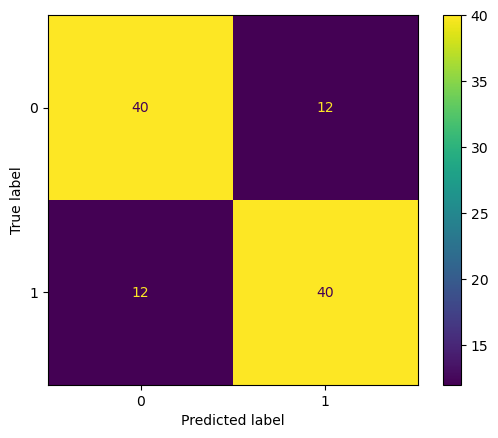

In [34]:
y_pred = classifier.predict(data)
# 5. Build and show confusion matrix
cm = confusion_matrix(labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# After you predict
f1 = f1_score(labels, y_pred, average='macro')  # or 'micro', 'weighted', etc.
print("F1 Score:", f1)

F1 Score: 0.7692307692307693


In [ ]:
observables = SparsePauliOp.from_list([
    ("ZIIIIIIII", 1),   # horizontal (top row start)
    ("ZZIIIIIII", 1),   # horizontal (top row start)
    ("IZZIIIIII", 1),   # horizontal (middle row start)
    ("IIIZZIIII", 1),   # horizontal (bottom row start)
    ("ZIZIIIIII", 1),   # vertical (1st col)
    ("IZIZIIIII", 1),   # vertical (2nd col)
    ("IIZIZIIII", 1),   # vertical (3rd col)
    ("ZIIIZIIII", 1),   # diagonal (\)
    ("IIZIZIZII", 1)    # anti-diagonal (/)
])
estimator = StatevectorEstimator()

qnn = EstimatorQNN(
    circuit=qcnn_circuit,
    input_params=input_params,
    weight_params=weight_params,
    estimator=estimator,
    observables=observables,
)

initial_point = np.random.rand(qnn.num_weights)
loss_vals = []
batch_size = 16
num_batches = int(np.ceil(len(data) / batch_size))

def callback_graph(weights, loss):
    correct = 0
    for i in range(num_batches):
        batch_data = data[i * batch_size:(i + 1) * batch_size]
        batch_labels = labels[i * batch_size:(i + 1) * batch_size]
    print(f"Loss: {loss:.4f}")
    loss_vals.append(loss)
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=100),
    initial_point=initial_point,
    loss="squared_error",
    callback=callback_graph,
)



classifier.fit(data, labels)
accuracy = classifier.score(data, labels)
print(f"Final Accuracy: {accuracy:.2f}")


Loss: 0.9664
Loss: 0.9711
Loss: 0.9676
Loss: 0.9684
Loss: 0.9669
Loss: 0.9643
Loss: 0.9726
Loss: 0.9688
Loss: 0.9689
Loss: 0.9682
Loss: 0.9679
Loss: 0.9724
Loss: 0.9658
Loss: 0.9667
Loss: 0.9684
Loss: 0.9697
Loss: 0.9741
Loss: 0.9689
Loss: 0.9704
Loss: 0.9646
Loss: 0.9678
Loss: 0.9702
Loss: 0.9743
Loss: 0.9695
Loss: 0.9670
Loss: 0.9379
Loss: 0.9421
Loss: 1.0284
Loss: 0.9406
Loss: 0.9342
Loss: 0.9395
Loss: 0.9399
Loss: 0.9396
Loss: 0.9346
Loss: 0.9440
Loss: 0.9351
Loss: 0.9352
Loss: 0.9422
Loss: 0.9351
Loss: 0.9396
Loss: 0.9423
Loss: 0.9350
Loss: 0.9381
Loss: 0.9402
Loss: 0.9407
Loss: 0.9378
Loss: 0.9419
Loss: 0.9349
Loss: 0.9400
Loss: 0.9395
Loss: 0.9434
Loss: 0.9407
Loss: 0.9428
Loss: 0.9374
Loss: 0.9349
Loss: 0.9392
Loss: 0.9372
Loss: 0.9380
Loss: 0.9352
Loss: 0.9442
Loss: 0.9471
Loss: 0.9343
Loss: 0.9355


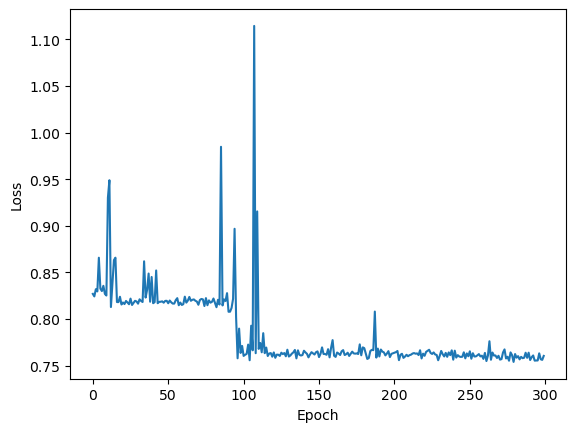

In [33]:
plt.plot(loss_vals)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:
predictions = classifier.predict(data)
print(predictions)

[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]]


In [ ]:
cr = 0
for i in range(104):  # Show first 10 samples
    # print(f"Predicted: {predictions[i]}, Actual: {labels[i]}")
    if(predictions[i] == labels[i]):
      cr += 1
print(cr)

79


In [ ]:
observables = SparsePauliOp.from_list([
    ("ZIIIIIIII", 1),   # horizontal (top row start)
    ("ZZIIIIIII", 1),   # horizontal (top row start)
    ("IZZIIIIII", 1),   # horizontal (middle row start)
    ("IIIZZIIII", 1),   # horizontal (bottom row start)
    ("ZIZIIIIII", 1),   # vertical (1st col)
    ("IZIZIIIII", 1),   # vertical (2nd col)
    ("IIZIZIIII", 1),   # vertical (3rd col)
    ("ZIIIZIIII", 1),   # diagonal (\)
    ("IIZIZIZII", 1)    # anti-diagonal (/)
])
estimator = StatevectorEstimator()

qnn = EstimatorQNN(
    circuit=qcnn_circuit,
    input_params=input_params,
    weight_params=weight_params,
    estimator=estimator,
    observables=observables,
)

initial_point = np.random.rand(qnn.num_weights)
loss_vals = []
batch_size = 16
num_batches = int(np.ceil(len(data) / batch_size))

def callback_graph(weights, loss):
    correct = 0
    for i in range(num_batches):
        batch_data = data[i * batch_size:(i + 1) * batch_size]
        batch_labels = labels[i * batch_size:(i + 1) * batch_size]
    print(f"Loss: {loss:.4f}")
    loss_vals.append(loss)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=SPSA(maxiter=100),
    initial_point=initial_point,
    loss="cross_entropy",
    callback=callback_graph,
)



classifier.fit(data, labels)
accuracy = classifier.score(data, labels)
print(f"Final Accuracy: {accuracy:.2f}")


Final Accuracy: 0.77


In [ ]:
observables = SparsePauliOp.from_list([
    ("ZIIIIIIII", 1),   # horizontal (top row start)
    ("ZZIIIIIII", 1),   # horizontal (top row start)
    ("IZZIIIIII", 1),   # horizontal (middle row start)
    ("IIIZZIIII", 1),   # horizontal (bottom row start)
    ("ZIZIIIIII", 1),   # vertical (1st col)
    ("IZIZIIIII", 1),   # vertical (2nd col)
    ("IIZIZIIII", 1),   # vertical (3rd col)
    ("ZIIIZIIII", 1),   # diagonal (\)
    ("IIZIZIZII", 1)    # anti-diagonal (/)
])
estimator = StatevectorEstimator()

qnn = EstimatorQNN(
    circuit=qcnn_circuit,
    input_params=input_params,
    weight_params=weight_params,
    estimator=estimator,
    observables=observables,
)

initial_point = np.random.rand(qnn.num_weights)
loss_vals = []
batch_size = 16
num_batches = int(np.ceil(len(data) / batch_size))

def callback_graph(weights, loss):
    correct = 0
    for i in range(num_batches):
        batch_data = data[i * batch_size:(i + 1) * batch_size]
        batch_labels = labels[i * batch_size:(i + 1) * batch_size]
    print(f"Loss: {loss:.4f}")
    loss_vals.append(loss)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=SPSA(maxiter=100),
    initial_point=initial_point,
    loss="squared_error",
    callback=callback_graph,
)



classifier.fit(data, labels)
accuracy = classifier.score(data, labels)
print(f"Final Accuracy: {accuracy:.2f}")
